In [1]:
import nltk
from nltk.stem.snowball import SnowballStemmer;from nltk import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer; from sklearn import linear_model
from sklearn.model_selection import KFold
from nltk.stem import WordNetLemmatizer
from nltk.corpus import sentiwordnet as swn
from matplotlib import pyplot as plt
# 라이브러리 로드 
from sklearn.feature_extraction.text import HashingVectorizer
from konlpy.tag import *
from konlpy.utils import pprint
from sklearn.pipeline import Pipeline

#import lda
import pandas as pd
import numpy as np
import re
import os
import sys
import json
import itertools

from konlpy.tag import Kkma, Komoran, Okt, Mecab
import soynlp
import re
import collections
import itertools
import requests
import csv
import time
import math
import operator

from tqdm import tqdm
from collections import Counter
from collections import defaultdict
from pandas import read_table
from bs4 import BeautifulSoup
from nltk.corpus import stopwords

############################################################################

# 한국어 nlp
from konlpy.tag import *   # 모든 형태소분석기 import 하기
okt = Okt()

# 영어 nlp 관련
from nltk.tokenize import word_tokenize

# 시각화 관련
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter
from PIL import Image
# 그래프에서 한글 폰트 깨지는 문제에 대한 대처(전역 글꼴 설정)
import matplotlib.font_manager as fm
import warnings
warnings.filterwarnings(action='ignore') 

import matplotlib
matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] =False

# 기타
from tqdm import tqdm_notebook, tqdm   # for문 진행상황 눈으로 확인 (loading bar)
import datetime
#########################################################
import pyecharts
#pyecharts.online()
from pyecharts.charts import Line, Bar, Pie #,Overlap
from pyecharts.faker import Faker
from pyecharts import options as opts
from IPython.display import display, Image

In [9]:
df = pd.read_csv('data/후드p2,3,5,6,7,8.csv')
df_origin = pd.read_csv('data/후드p2,3,5,6,7,8.csv')



### 형태소 분리

In [3]:
df = df['content']
df_origin = df_origin['content']
df=df.dropna()
nouns = []

for i in df:
    try:
        nouns.append(okt.nouns(i))
    except:
        continue
nouns = list(itertools.chain(*nouns))

In [7]:
a = []
for i in nouns:
    if (len(i) != 1):
        a.append(i)

count = Counter(a).most_common()
count = pd.DataFrame(count)
count.columns = ['word','count']
count[count['count']>1].describe()

,count
count,1911.000000
mean,24.251701
std,94.813308
min,2.000000
25%,2.000000
50%,4.000000
75%,12.000000
max,1985.000000


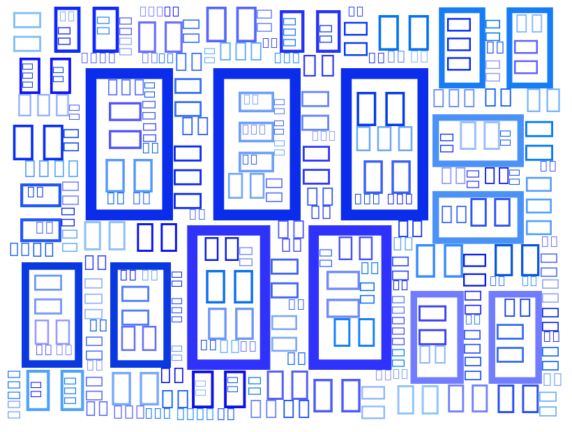

In [5]:
#1번 워드클라우드
data = dict(zip(count['word'].tolist(), count['count'].tolist()))
def color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl({:d},{:d}%, {:d}%)".format(np.random.randint(210,240),np.random.randint(90,100),np.random.randint(45,80)))

wc = WordCloud(#font_path='C:/USERS/김주은/APPDATA/LOCAL/MICROSOFT/WINDOWS/FONTS/NANUMSQUARE_ACR.TTF', #폰트
               background_color='White', color_func=color_func,                             #배경색
               width=800, height=600 )                                         #단어갯수
cloud = wc.generate_from_frequencies(data)                            #사전형태의 데이터 넣기

plt.figure(figsize=(10,10))                                           #액자사이즈설정
plt.axis('off')                                                       #테두리 선 없애기
plt.imshow(cloud,interpolation="bilinear")

### 토픽모델링

In [10]:
#토픽모델링을 위한 단어 리스트 만들기
word_list = []
for i in range(len(df)):
  temp_list = df['content'].tolist()
  temp_list = [x for x in temp_list if pd.isnull(x)==False] # nan 제거 
  temp_str = ' '.join(temp_list) # list -> str
  word_list.append(temp_str)

content_df = df.copy()

In [13]:
# 1. Vector화
#LDA 는 Count기반의 Vectorizer만 적용 
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(max_df=0.7, max_features=1000, min_df=10, ngram_range=(1,2))
    # 10개의 문서 미만으로 등장하는 단어는 제외, 전체의 80% 이상으로 자주 등장하는 단어는 제외
    # bigram도 포함
    
feat_vect = count_vectorizer.fit_transform(word_list) # 오류 -> 해결(list->str)
print('CountVectorizer Shape:', feat_vect.shape)

MemoryError: 

In [12]:
# 2. 토픽모델링: LDA
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=5)  # 토픽 수는 5개로 설정
lda.fit(feat_vect)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=5, n_jobs=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

NameError: name 'feat_vect' is not defined

In [ ]:
# 3. 토픽별 연관어 출력
def display_topics(model, feature_names, num_top_words):
    for topic_index, topic in enumerate(model.components_):
        print('Topic #', topic_index+1)

        # components_ array에서 가장 값이 큰 순으로 정렬했을 때, 그 값의 array index를 반환. 
        topic_word_indexes = topic.argsort()[::-1]
        top_indexes=topic_word_indexes[:num_top_words]
        
        # top_indexes대상인 index별로 feature_names에 해당하는 word feature 추출 후 join으로 concat
        feature_concat = ' '.join([feature_names[i] for i in top_indexes])                
        print(feature_concat)

# CountVectorizer객체내의 전체 word들의 명칭을 get_features_names( )를 통해 추출
feature_names = count_vectorizer.get_feature_names()

# Topic별 가장 연관도가 높은 word를 10개만 추출
display_topics(lda, feature_names, 10)

In [ ]:
# 4. ⁣각 문서별로 가장 가까운 topic으로 할당

# 문서별로, 가장 확률이 높은 topic으로 할당해줌
doc_topic = lda.transform(feat_vect)
doc_per_topic_list = []
for n in range(doc_topic.shape[0]):
    topic_most_pr = doc_topic[n].argmax()
    topic_pr = doc_topic[n].max()
    doc_per_topic_list.append([n, topic_most_pr, topic_pr])
    
doc_topic_df = pd.DataFrame(doc_per_topic_list, columns=['Doc_Num', 'Topic', 'Percentage'])
display(doc_topic_df.head())

# 실제 데이터와 조인 
doc_topic_df = doc_topic_df.join(df)
doc_topic_df.tail()

# 5. 토픽별 문서 수 계산
display(doc_topic_df.groupby('Topic')[['Doc_Num']].count())

# 6. LDA 시각화: pyLDAvis
pyLDAvis.enable_notebook()
vis = pyLDAvis.sklearn.prepare(lda, feat_vect, count_vectorizer)
pyLDAvis.display(vis) 